# 0. Data Visualizations

In this notebook, I show some images of the dogs to be classified.

The goal is to identify how many dog breeds we have, and see some pictures. So that later on, when working with the other files, we are more familiar with data
 

### 0.Import libraries

In [0]:
# We start by importing libraries
import time
import json
import copy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import PIL
from PIL import Image
from collections import OrderedDict

import torch
from torch import nn, optim
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F

import os


In [2]:
!pip3 install torch torchvision


In [3]:
import PIL
print(PIL.PILLOW_VERSION)

4.1.1


In [4]:
!apt-get install


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


### 1.Prepare images for classification

In [0]:
#The following code will help us when dealing with images to be used in different classification models#
#from PIL import Image
#import torchvision.transforms as transforms
#from torch.autograd import Variable

def process_image_to_tensor(image):

    # define transforms for the training data and testing data
    prediction_transforms = transforms.Compose([transforms.Resize(224),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])
    
    img_pil = Image.open( image ).convert('RGB')
    img_tensor = prediction_transforms( img_pil )[:3,:,:].unsqueeze(0)
    
    return img_tensor


# helper function for un-normalizing an image  - from STYLE TRANSFER exercise
# and converting it from a Tensor image to a NumPy image for display
def image_convert(tensor):
    """ This is to display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

#### 1.1 Specify Directories

In [0]:
# Specify directories
data_dir = 'dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [0]:
import os
from torchvision import datasets

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
# Batch size
batch_size = 20
# For faster computation, setting num_workers
num_workers = 0

# Transforms for the training, validation, and testing sets
data_transforms = {
    'train'      : transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),

    'valid'      : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])]),
    'test'       : transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
}

# Loading the datasets with ImageFolder
image_datasets = {
    'train'  : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'valid'  : datasets.ImageFolder(valid_dir, transform=data_transforms['valid']),
    'test'   : datasets.ImageFolder(test_dir, transform=data_transforms['test'])
}

# Using the image datasets and the trainforms to define dataloaders
loaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size = 32, shuffle=True, num_workers = num_workers),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size = 16),
    'test'  : torch.utils.data.DataLoader(image_datasets['test'], batch_size = 16)}

### 2.Set up CUDA if available


In [8]:

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


### 3.Image visualization

In [9]:
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  6680
Num test images:  836


In [10]:

# get classes of training datas
class_names = train_data.classes
number_classes = len(class_names)

# correct output-size of the CNN
param_output_size = len(class_names)

print("number of classes:", number_classes)
print("")
print("class names: \n", class_names)

number of classes: 133

class names: 
 ['001.Affenpinscher', '002.Afghan_hound', '003.Airedale_terrier', '004.Akita', '005.Alaskan_malamute', '006.American_eskimo_dog', '007.American_foxhound', '008.American_staffordshire_terrier', '009.American_water_spaniel', '010.Anatolian_shepherd_dog', '011.Australian_cattle_dog', '012.Australian_shepherd', '013.Australian_terrier', '014.Basenji', '015.Basset_hound', '016.Beagle', '017.Bearded_collie', '018.Beauceron', '019.Bedlington_terrier', '020.Belgian_malinois', '021.Belgian_sheepdog', '022.Belgian_tervuren', '023.Bernese_mountain_dog', '024.Bichon_frise', '025.Black_and_tan_coonhound', '026.Black_russian_terrier', '027.Bloodhound', '028.Bluetick_coonhound', '029.Border_collie', '030.Border_terrier', '031.Borzoi', '032.Boston_terrier', '033.Bouvier_des_flandres', '034.Boxer', '035.Boykin_spaniel', '036.Briard', '037.Brittany', '038.Brussels_griffon', '039.Bull_terrier', '040.Bulldog', '041.Bullmastiff', '042.Cairn_terrier', '043.Canaan_dog',

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


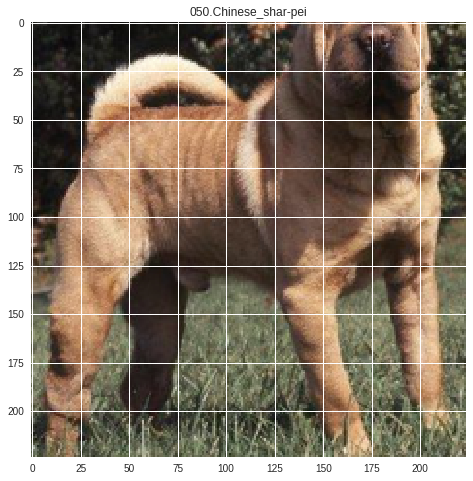

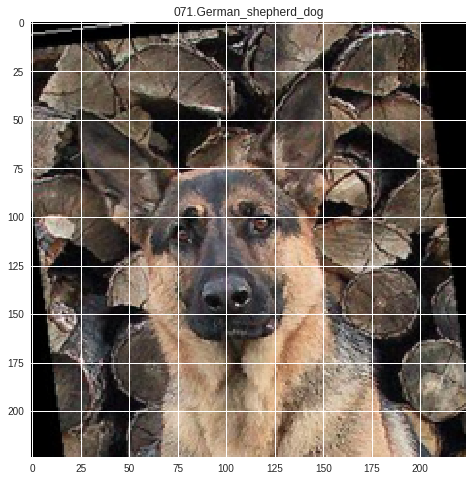

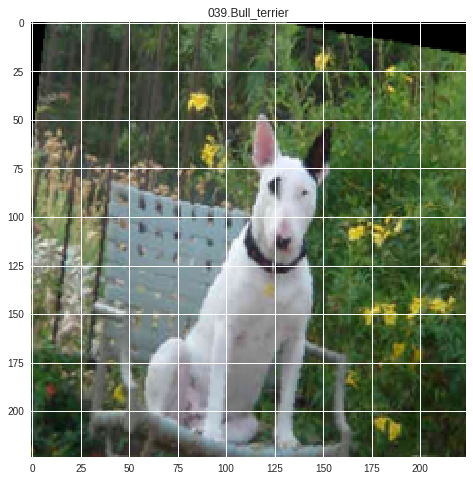

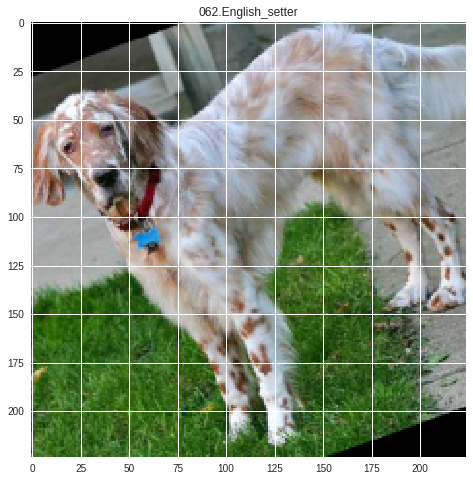

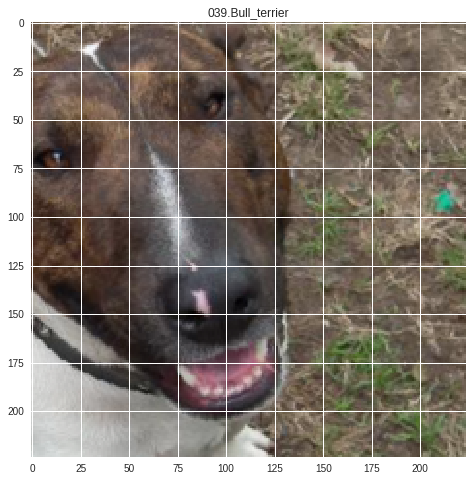

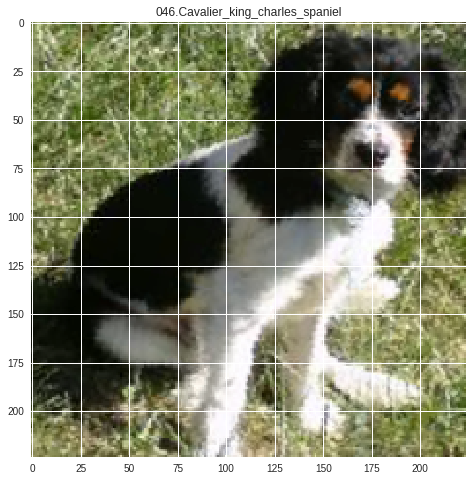

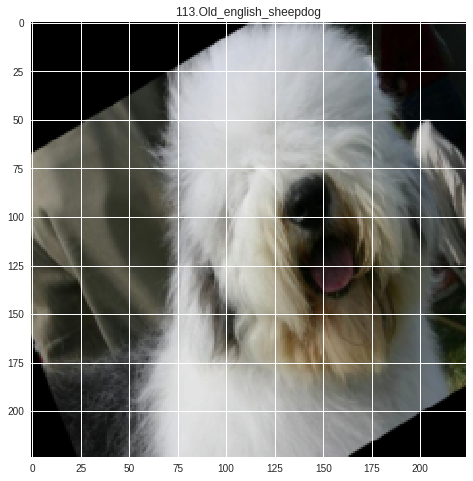

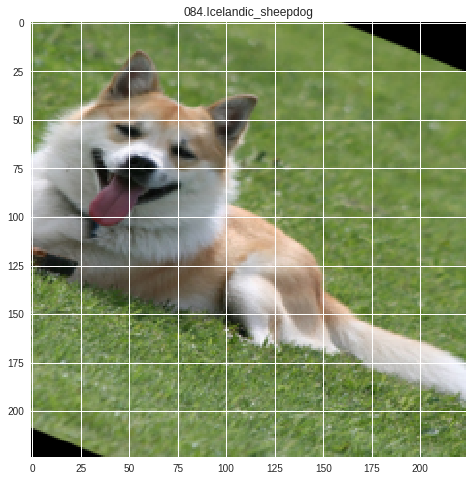

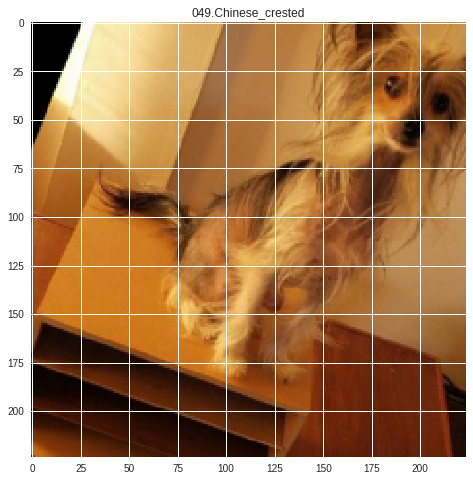

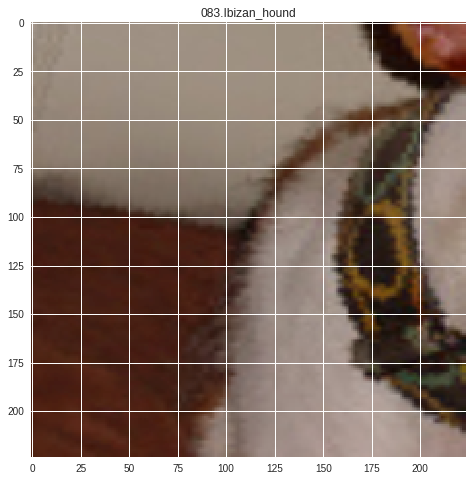

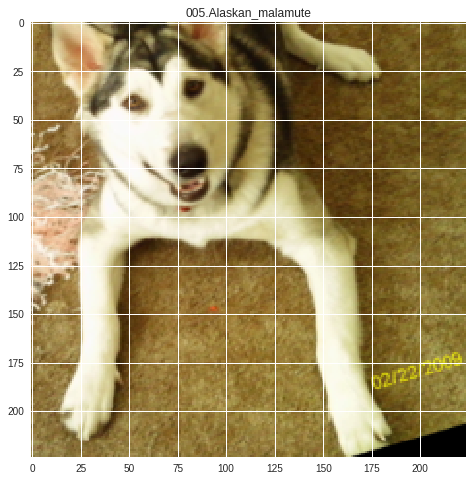

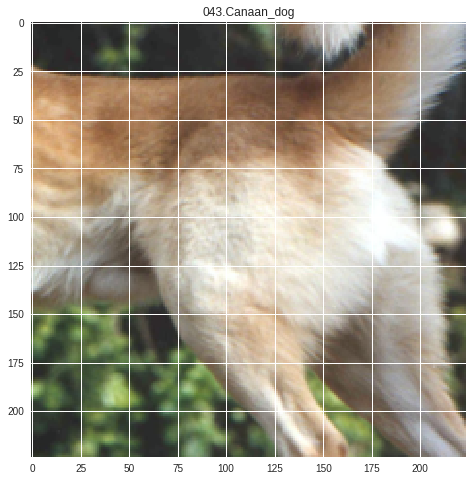

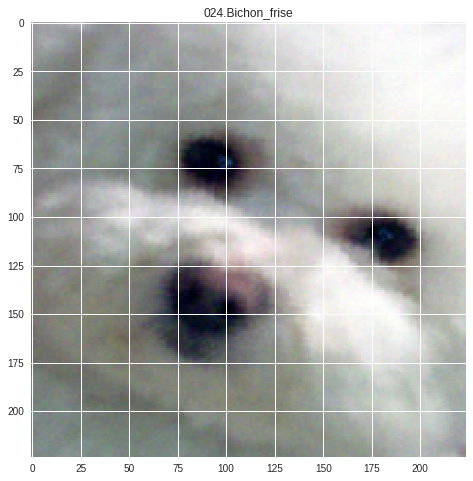

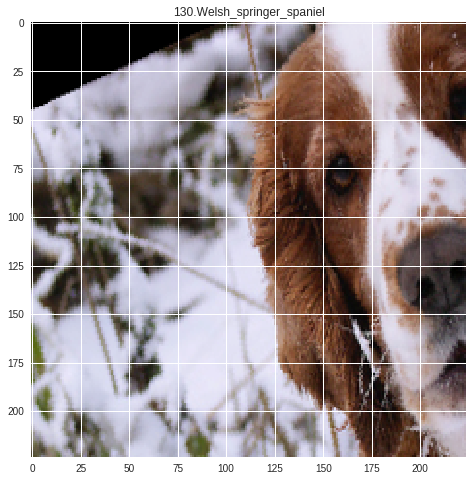

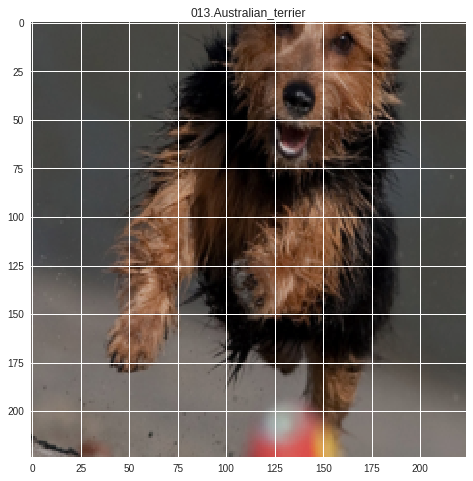

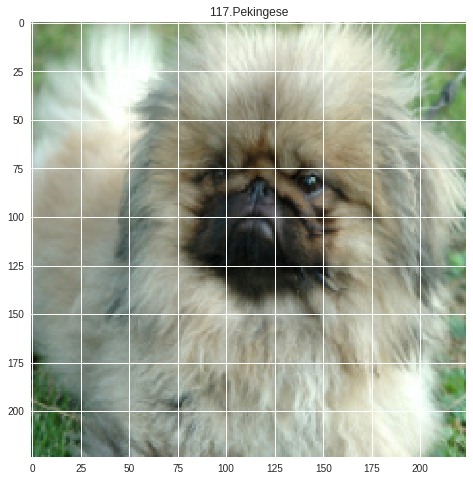

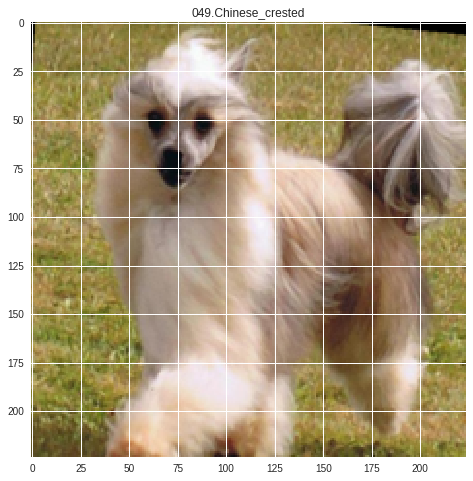

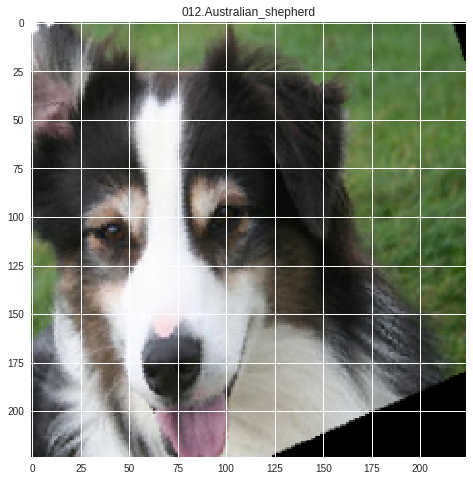

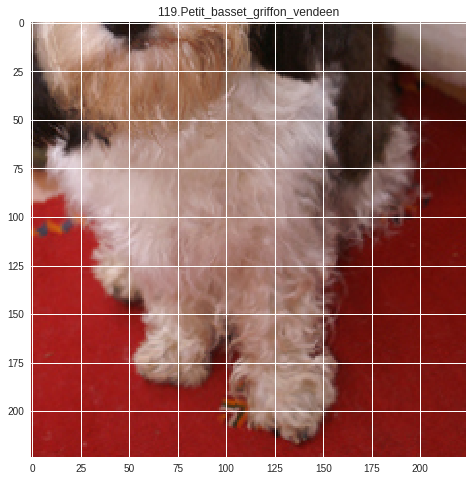

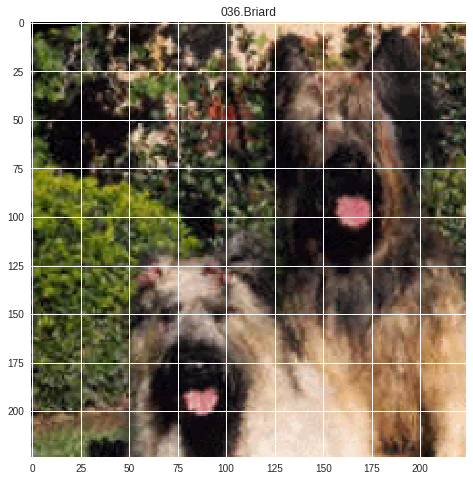

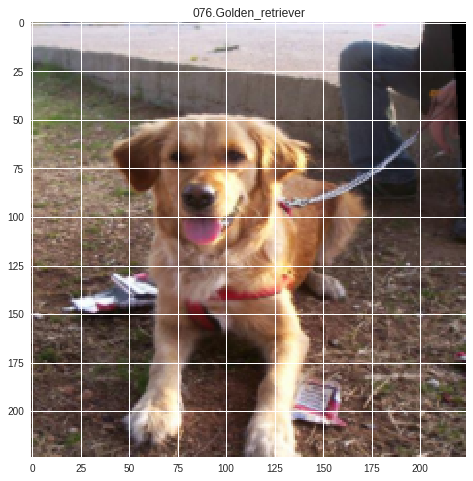

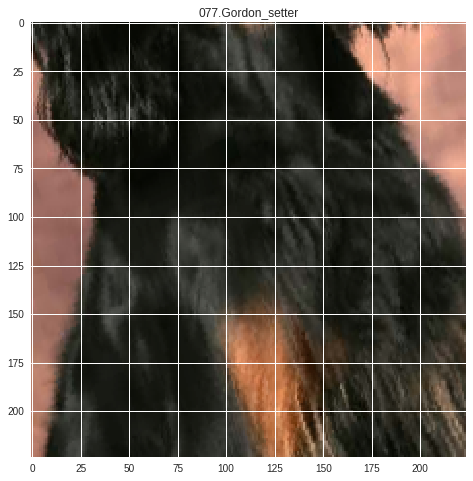

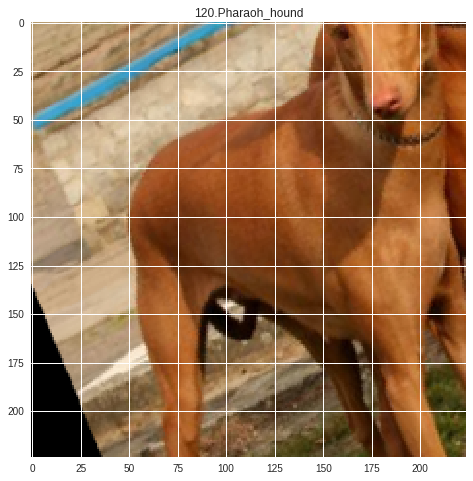

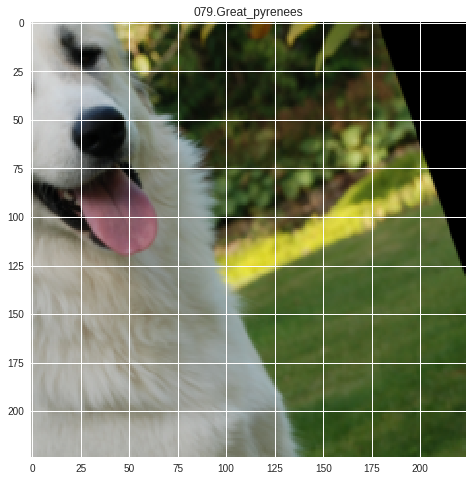

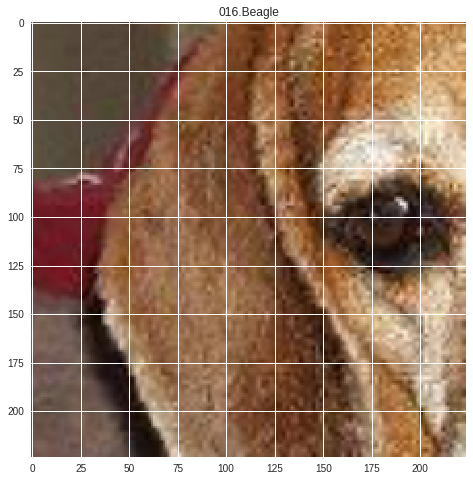

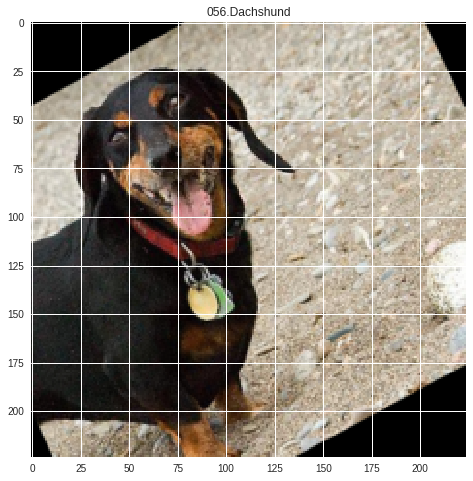

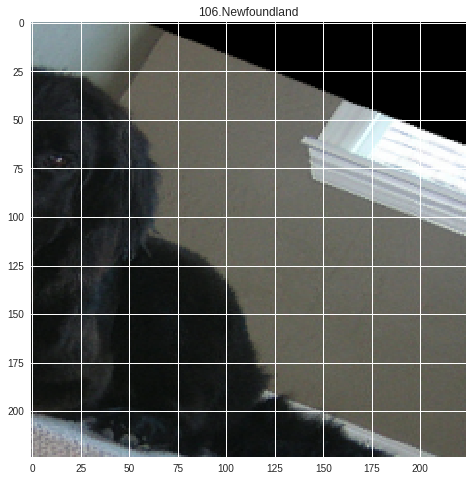

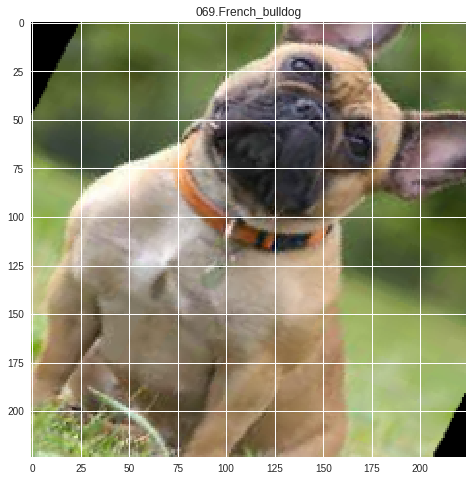

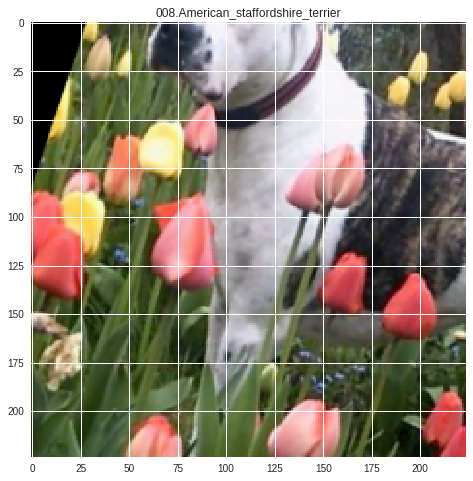

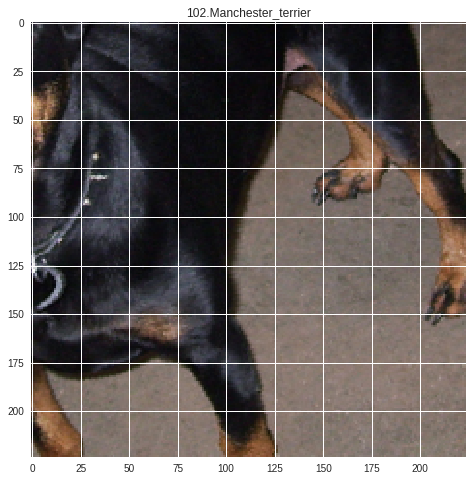

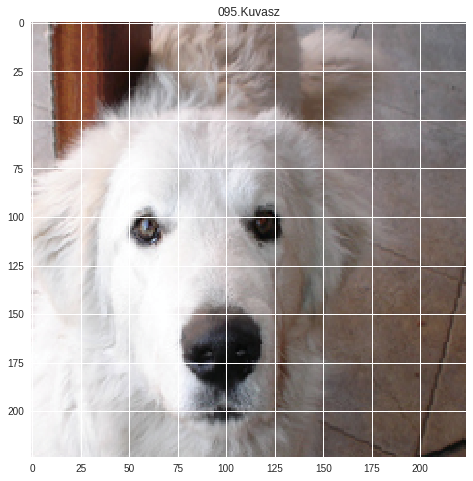

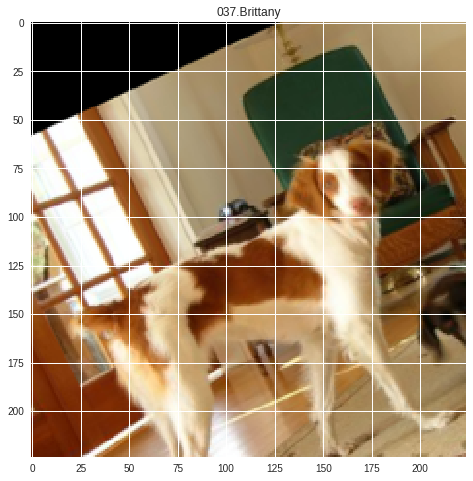

In [11]:
# get a batch of training datas
inputs, classes = next( iter(loaders['train']) )

for image, label in zip(inputs, classes): 
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    # normalize image
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
     
    fig = plt.figure(figsize=(12,8))
    plt.imshow(image)
    plt.title(class_names[label])